# PySpark PyTorch Inference
Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [1]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
torch.__version__

'1.10.2+cpu'

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


### Create model

In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Train Model

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301414  [    0/60000]
loss: 2.296061  [ 6400/60000]
loss: 2.273273  [12800/60000]
loss: 2.267891  [19200/60000]
loss: 2.263589  [25600/60000]
loss: 2.224504  [32000/60000]
loss: 2.235053  [38400/60000]
loss: 2.204235  [44800/60000]
loss: 2.200346  [51200/60000]
loss: 2.170399  [57600/60000]
Test Error: 
 Accuracy: 38.3%, Avg loss: 2.166341 

Epoch 2
-------------------------------
loss: 2.170680  [    0/60000]
loss: 2.172003  [ 6400/60000]
loss: 2.106007  [12800/60000]
loss: 2.120713  [19200/60000]
loss: 2.094255  [25600/60000]
loss: 2.018496  [32000/60000]
loss: 2.052631  [38400/60000]
loss: 1.974799  [44800/60000]
loss: 1.977118  [51200/60000]
loss: 1.908318  [57600/60000]
Test Error: 
 Accuracy: 55.5%, Avg loss: 1.907357 

Epoch 3
-------------------------------
loss: 1.930629  [    0/60000]
loss: 1.919093  [ 6400/60000]
loss: 1.788064  [12800/60000]
loss: 1.829580  [19200/60000]
loss: 1.743990  [25600/60000]
loss: 1.671982  [32000/600

### Save Model State

In [10]:
torch.save(model.state_dict(), "model_weights.pt")
print("Saved PyTorch Model State to model_weights.pt")

Saved PyTorch Model State to model_weights.pt


### Load Model State

In [11]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model_weights.pt"))

<All keys matched successfully>

### Predict

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [13]:
model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Save Entire Model (using pickle)

In [14]:
torch.save(model, "model.pt")

### Load Entire Model (using pickle)

In [15]:
new_model = torch.load("model.pt")

In [16]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = new_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


## PySpark

In [17]:
import pandas as pd
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType

### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [18]:
data = test_data.data.numpy()
data.shape, data.dtype

((10000, 28, 28), dtype('uint8'))

In [19]:
data = data.reshape(10000, 784) / 255.0
data.shape, data.dtype

((10000, 784), dtype('float64'))

In [20]:
test_pdf = pd.DataFrame(data)

In [21]:
%%time
# 1 column of array<float>
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

CPU times: user 214 ms, sys: 48 ms, total: 262 ms
Wall time: 262 ms


(10000, 1)

In [22]:
%%time
# force FloatType since Pandas uses double
schema = StructType([StructField("data",ArrayType(FloatType()), True)])
df = spark.createDataFrame(pdf, schema)

CPU times: user 3.26 s, sys: 63.5 ms, total: 3.32 s
Wall time: 5.26 s


In [23]:
df.schema

StructType(List(StructField(data,ArrayType(FloatType,true),true)))

### Save the test dataset as parquet files

In [24]:
%%time
df.write.mode("overwrite").parquet("fashion_mnist_test")

22/02/23 10:32:16 WARN TaskSetManager: Stage 0 contains a task of very large size (4315 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 9.1 ms, sys: 17 µs, total: 9.11 ms
Wall time: 4.16 s


### Check arrow memory configuration

In [25]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "512")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty"

22/02/23 10:32:19 WARN TaskSetManager: Stage 1 contains a task of very large size (4315 KiB). The maximum recommended task size is 1000 KiB.


## Inference using Spark ML Model

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import sparkext
import torch
from torch import nn

In [27]:
df = spark.read.parquet("fashion_mnist_test")

### Define Model

In [28]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [29]:
model = sparkext.torch.Model("model.pt").setInputShape((-1,28,28))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [30]:
predictions = model.transform(df)

/home/leey/devpub/spark/python/pyspark/sql/pandas/functions.py:389: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [31]:
predictions.write.mode("overwrite").parquet("mnist_predictions")

In [32]:
predictions.take(1)

[Row(prediction=[0.9725292325019836, -2.625725269317627, 2.3731212615966797, -0.63252192735672, 2.2978780269622803, -1.304521083831787, 2.1218631267547607, -2.665595531463623, 1.6429815292358398, -1.3077211380004883])]

In [33]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [34]:
img = np.array(df.take(1)[0].data)

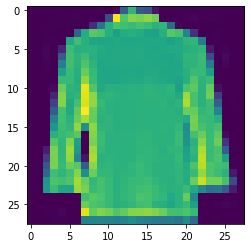

In [35]:
plt.figure()
plt.imshow(img.reshape(28,28))
plt.show()